In [1]:
from coffea.nanoevents import BaseSchema, NanoEventsFactory
import dask_awkward as dak
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import hist
import mplhep as hep
import numba
import vector
vector.register_awkward()

In [2]:
events = NanoEventsFactory.from_root(
    file="../data/p8_ee_ZH_ecm240/events_101027117.root:events",
    schemaclass=BaseSchema,
    # schemaclass=DelphesSchema, Doesn't work 
    # schemaclass=NanoAODSchema.v7, Doesn't work
    metadata={
        "path":"/eos/experiment/fcc/ee/generation/DelphesEvents/spring2021/IDEA/p8_ee_ZH_ecm240/events_101027117.root",
        "name":"p8_ee_ZH_ecm240",
        "process":"ZH to mumu, ecm=240 GeV"
    }
).events()

In [3]:
events.fields

['Electron',
 'Electron#0',
 'Electron#0/Electron#0.index',
 'Electron#0/Electron#0.collectionID',
 'Muon',
 'Muon#0',
 'Muon#0/Muon#0.index',
 'Muon#0/Muon#0.collectionID',
 'AllMuon',
 'AllMuon#0',
 'AllMuon#0/AllMuon#0.index',
 'AllMuon#0/AllMuon#0.collectionID',
 'EFlowNeutralHadron',
 'EFlowNeutralHadron/EFlowNeutralHadron.type',
 'EFlowNeutralHadron/EFlowNeutralHadron.energy',
 'EFlowNeutralHadron/EFlowNeutralHadron.energyError',
 'EFlowNeutralHadron/EFlowNeutralHadron.position.x',
 'EFlowNeutralHadron/EFlowNeutralHadron.position.y',
 'EFlowNeutralHadron/EFlowNeutralHadron.position.z',
 'EFlowNeutralHadron/EFlowNeutralHadron.positionError[6]',
 'EFlowNeutralHadron/EFlowNeutralHadron.iTheta',
 'EFlowNeutralHadron/EFlowNeutralHadron.phi',
 'EFlowNeutralHadron/EFlowNeutralHadron.directionError.x',
 'EFlowNeutralHadron/EFlowNeutralHadron.directionError.y',
 'EFlowNeutralHadron/EFlowNeutralHadron.directionError.z',
 'EFlowNeutralHadron/EFlowNeutralHadron.shapeParameters_begin',
 'EFlo

In [4]:
mu_0_index = events['Muon#0/Muon#0.index'].compute()

In [5]:
Recon = events['ReconstructedParticles/ReconstructedParticles.energy'].compute()

In [6]:
useful_events = events[ak.num(Recon) > 0]

In [7]:
useful_events['ReconstructedParticles/ReconstructedParticles.energy'].compute()

<Array [[0.388, 1.19, ..., 2.9, 1.22], ...] type='99984 * [var * float32[pa...'>

In [8]:
Reco_E = useful_events['ReconstructedParticles/ReconstructedParticles.energy'].compute()
Reco_px = useful_events['ReconstructedParticles/ReconstructedParticles.momentum.x'].compute()
Reco_py = useful_events['ReconstructedParticles/ReconstructedParticles.momentum.y'].compute()
Reco_pz = useful_events['ReconstructedParticles/ReconstructedParticles.momentum.z'].compute()
Muon_index = useful_events['Muon#0/Muon#0.index'].compute()

In [9]:
Reco_E[:,[0]]

<Array [[0.388], [0.305], ..., [0.539], [30.6]] type='99984 * 1 * float32[p...'>

In [10]:
def index_mask(input_array, index_array):
    if len(input_array) != len(index_array) :
        raise Exception('Length of Input_array and index_array does not match!')
    counts = len(ak.count(input_array, axis = 1))
    @numba.jit
    def numba_wrap(input_array, index_array,counts):
        output_array = []
        for event_index in range(counts):
            event_mask = index_array[event_index]
            reco_list = input_array[event_index]
            output_array.append([reco_list[i] for i in  event_mask])
        return output_array
    return ak.Array(numba_wrap(input_array,index_array,counts))

In [11]:
Muon_E = index_mask(Reco_E, Muon_index)
Muon_px = index_mask(Reco_px, Muon_index)
Muon_py = index_mask(Reco_py, Muon_index)
Muon_pz = index_mask(Reco_pz, Muon_index)

In [12]:
Muon_E[ak.num(Muon_E)>0]

<Array [[43.4], [61.6, 41.5], ..., [29.8], [36.6]] type='11229 * var * float64'>

In [13]:
import hist

In [61]:
mu_px = hist.Hist.new.Reg(100,0,200).Double().fill(ak.flatten(Muon_px))
mu_py = hist.Hist.new.Reg(100,0,200).Double().fill(ak.flatten(Muon_py))
mu_pz = hist.Hist.new.Reg(100,0,200).Double().fill(ak.flatten(Muon_pz))

In [62]:
mu_px

Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 7467.0 (14892.0 with flow)

In [63]:
mu_py

Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 7333.0 (14892.0 with flow)

In [64]:
mu_px+mu_py

Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 14800.0 (29784.0 with flow)

In [65]:
hists = [mu_px, mu_py]

In [66]:
sum(hists)

Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 14800.0 (29784.0 with flow)

In [67]:
numeric1 = {"p1":mu_px,"p2":mu_py,"p3":mu_pz}
numeric2 = {"p1":mu_pz,"p2":mu_py,"p3":mu_px}

In [68]:
numeric1

{'p1': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 7467.0 (14892.0 with flow),
 'p2': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 7333.0 (14892.0 with flow),
 'p3': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 7348.0 (14892.0 with flow)}

In [69]:
numeric2

{'p1': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 7348.0 (14892.0 with flow),
 'p2': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 7333.0 (14892.0 with flow),
 'p3': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 7467.0 (14892.0 with flow)}

In [70]:
from coffea import processor
import json

In [71]:
def accumulate(dict1, dict2):
    """
    Merges two dictionaries and adds up the values of common keys.
    
    Parameters:
    dict1 (dict): The first dictionary.
    dict2 (dict): The second dictionary.
    
    Returns:
    dict: A dictionary with combined keys and values summed for common keys.
    """
    merged = dict1.copy()  # Start with the first dictionary's keys and values
    for key, value in dict2.items():
        if key in merged:
            merged[key] += value  # Add values if the key is common
        else:
            merged[key] = value  # Otherwise, add the new key-value pair
    return merged

In [72]:
def accumulate2(dicts):
    """
    Merges an array of dictionaries and adds up the values of common keys.
    
    Parameters:
    dicts (list): A list of dictionaries to be merged.
    
    Returns:
    dict: A dictionary with combined keys and values summed for common keys.
    """
    dict = {}
    
    for dictionary in dicts:
        for key, value in dictionary.items():
            if key in dict:
                dict[key] += value  # Add values if the key is common
            else:
                dict[key] = value  # Otherwise, add the new key-value pair
                
    return dict

In [73]:
a = accumulate2([numeric1,numeric2])
a

{'p1': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 14815.0 (29784.0 with flow),
 'p2': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 14666.0 (29784.0 with flow),
 'p3': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 22163.0 (44676.0 with flow)}

In [32]:
b = accumulate(numeric1,numeric2)
b

{'p1': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 251379.0 (506328.0 with flow),
 'p2': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 117328.0 (238272.0 with flow),
 'p3': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 406639.0 (819060.0 with flow)}

In [43]:
a

{'p1': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 251379.0 (506328.0 with flow),
 'p2': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 117328.0 (238272.0 with flow),
 'p3': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 406639.0 (819060.0 with flow)}

In [75]:
a

{'p1': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 14815.0 (29784.0 with flow),
 'p2': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 14666.0 (29784.0 with flow),
 'p3': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 22163.0 (44676.0 with flow)}

In [76]:
accumulate2([a])

{'p1': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 14815.0 (29784.0 with flow),
 'p2': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 14666.0 (29784.0 with flow),
 'p3': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 22163.0 (44676.0 with flow)}

In [77]:
from coffea.util import load

In [78]:
a = load('outputs/FCCee/higgs/mH-recoil/mumu/mHrecoil_mumu.coffea')

In [81]:
zh = a['p8_ee_ZH_ecm240']['histograms']['sel0']
zz = a['p8_ee_ZZ_ecm240']['histograms']['sel0']
ww = a['p8_ee_WW_ecm240']['histograms']['sel0']

In [82]:
zh

{'Zm': Hist(Regular(125, 0, 250, label='Axis 0'), storage=Double()) # Sum: 6252.0,
 'Zm_zoom': Hist(Regular(40, 80, 100, label='Axis 0'), storage=Double()) # Sum: 4658.0 (6252.0 with flow),
 'Recoilm': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 5948.0 (6252.0 with flow),
 'Recoilm_zoom': Hist(Regular(200, 80, 160, label='Axis 0'), storage=Double()) # Sum: 5328.0 (6252.0 with flow),
 'Recoilm_zoom1': Hist(Regular(100, 120, 140, label='Axis 0'), storage=Double()) # Sum: 4738.0 (6252.0 with flow),
 'Recoilm_zoom2': Hist(Regular(200, 120, 140, label='Axis 0'), storage=Double()) # Sum: 4738.0 (6252.0 with flow),
 'Recoilm_zoom3': Hist(Regular(400, 120, 140, label='Axis 0'), storage=Double()) # Sum: 4738.0 (6252.0 with flow),
 'Recoilm_zoom4': Hist(Regular(800, 120, 140, label='Axis 0'), storage=Double()) # Sum: 4738.0 (6252.0 with flow),
 'Recoilm_zoom5': Hist(Regular(2000, 120, 140, label='Axis 0'), storage=Double()) # Sum: 4738.0 (6252.0 with flow),
 'Recoilm_zoom

In [83]:
zz

{'Zm': Hist(Regular(125, 0, 250, label='Axis 0'), storage=Double()) # Sum: 14411.0,
 'Zm_zoom': Hist(Regular(40, 80, 100, label='Axis 0'), storage=Double()) # Sum: 8759.0 (14411.0 with flow),
 'Recoilm': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 14021.0 (14411.0 with flow),
 'Recoilm_zoom': Hist(Regular(200, 80, 160, label='Axis 0'), storage=Double()) # Sum: 12340.0 (14411.0 with flow),
 'Recoilm_zoom1': Hist(Regular(100, 120, 140, label='Axis 0'), storage=Double()) # Sum: 1264.0 (14411.0 with flow),
 'Recoilm_zoom2': Hist(Regular(200, 120, 140, label='Axis 0'), storage=Double()) # Sum: 1264.0 (14411.0 with flow),
 'Recoilm_zoom3': Hist(Regular(400, 120, 140, label='Axis 0'), storage=Double()) # Sum: 1264.0 (14411.0 with flow),
 'Recoilm_zoom4': Hist(Regular(800, 120, 140, label='Axis 0'), storage=Double()) # Sum: 1264.0 (14411.0 with flow),
 'Recoilm_zoom5': Hist(Regular(2000, 120, 140, label='Axis 0'), storage=Double()) # Sum: 1264.0 (14411.0 with flow),
 'R

In [84]:
ww

{'Zm': Hist(Regular(125, 0, 250, label='Axis 0'), storage=Double()) # Sum: 2914.0,
 'Zm_zoom': Hist(Regular(40, 80, 100, label='Axis 0'), storage=Double()) # Sum: 334.0 (2914.0 with flow),
 'Recoilm': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 2851.0 (2914.0 with flow),
 'Recoilm_zoom': Hist(Regular(200, 80, 160, label='Axis 0'), storage=Double()) # Sum: 1306.0 (2914.0 with flow),
 'Recoilm_zoom1': Hist(Regular(100, 120, 140, label='Axis 0'), storage=Double()) # Sum: 272.0 (2914.0 with flow),
 'Recoilm_zoom2': Hist(Regular(200, 120, 140, label='Axis 0'), storage=Double()) # Sum: 272.0 (2914.0 with flow),
 'Recoilm_zoom3': Hist(Regular(400, 120, 140, label='Axis 0'), storage=Double()) # Sum: 272.0 (2914.0 with flow),
 'Recoilm_zoom4': Hist(Regular(800, 120, 140, label='Axis 0'), storage=Double()) # Sum: 272.0 (2914.0 with flow),
 'Recoilm_zoom5': Hist(Regular(2000, 120, 140, label='Axis 0'), storage=Double()) # Sum: 272.0 (2914.0 with flow),
 'Recoilm_zoom6': Hi

In [86]:
import mplhep as hep
import matplotlib.pyplot as plt

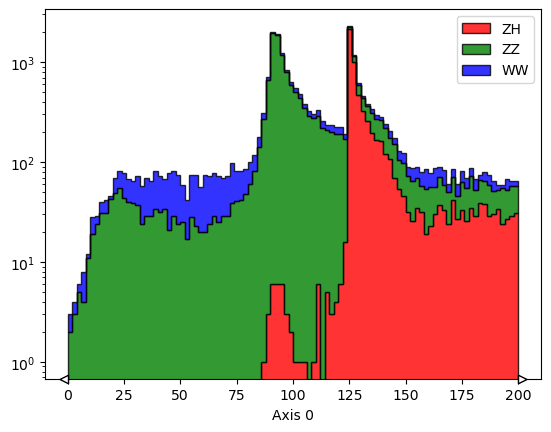

In [92]:
fig,ax=plt.subplots()
hep.histplot(
        [zh['Recoilm'],zz['Recoilm'],ww['Recoilm']],
        yerr=0,
        histtype='fill',
        label=['ZH','ZZ','WW'],
        color=['r','g','b'],
        alpha=0.8,
        stack=True,
        edgecolor='black',
        linewidth=1,
        ax=ax
    )
ax.legend()
ax.set_yscale('log')

In [96]:
zh['Zm'].sum()

6252.0